# Error fields
This notebook illustrates the error field computation using different techniques, including the so-called *Clever Poor Man's Error* (CPME) method.

In [1]:
using DIVAnd
using PyPlot
using Dates
using Statistics
using LinearAlgebra

## Data reading
Download the file (it not already done) and read it.

In [2]:
varname = "Salinity"
filename = "../data/WOD-Salinity-Provencal.nc"

if !isfile(filename)    
    download("https://dox.ulg.ac.be/index.php/s/PztJfSEnc8Cr3XN/download",filename)
else 
    @info "File already downloaded"
end

┌ Info: File already downloaded
└ @ Main In[2]:7


In [3]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadobs(Float64,filename,"Salinity");

## Topography and grid definition
See the notebook on [bathymetry](../2-Preprocessing/06-topography.ipynb) for more explanations.

Define domain and resolution, create the domain.

In [4]:
dx = dy = 0.125/2.
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

mask,(pm,pn),(xi,yi) = DIVAnd_rectdom(lonr,latr);

Download the bathymetry file and load it.

In [5]:
bathname = "../data/gebco_30sec_4.nc"
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[5]:5


In [6]:
bx,by,b = load_bath(bathname,true,lonr,latr);

Create a land-sea mask based on the bathymetry.

In [7]:
mask = falses(size(b,1),size(b,2))

for j = 1:size(b,2)
    for i = 1:size(b,1)
        mask[i,j] = b[i,j] >=1.0
    end
end

## Data selection for example

Cross validation, error calculations etc. assume independant data. Hence do not take high-resolution vertical profiles with all data but restrict yourself to specific small depth range. Here we limit outselves to August data at surface:

In [8]:
sel = (obsdepth .< 1) .& (Dates.month.(obstime) .== 8)

obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsid = obsid[sel];
@show (size(obsval))
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

size(obsval) = (1956,)


┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/obsstat.jl:75


              minimum and maximum of obs. dimension 1: (3.0763332843780518, 11.779999732971191)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (0.0, 0.9921539425849915)
              minimum and maximum of obs. dimension 4: (DateTime("1910-08-09T00:00:00"), DateTime("2014-08-28T19:36:00"))
                          minimum and maximum of data: (24.886999130249023, 39.18000030517578)


### Analysis
Analysis parameters have been calibrated in the other notebook [13-processing-parameter-optimization example.ipynb](13-processing-parameter-optimization). 

⚠ if the statistical parameters are incorrectly estimated, the error fields are meaningless and only provide an idea of data coverage.

The analysis parameters are:

In [9]:
len = 0.3
epsilon2 = 1.0;

Analysis `fi` using mean data as background.    
Structure `s` is stored for later use in error calculation.

In [10]:
fi, s = DIVAndrun(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval.-mean(obsval),len,epsilon2);

Create a simple plot of the analysis

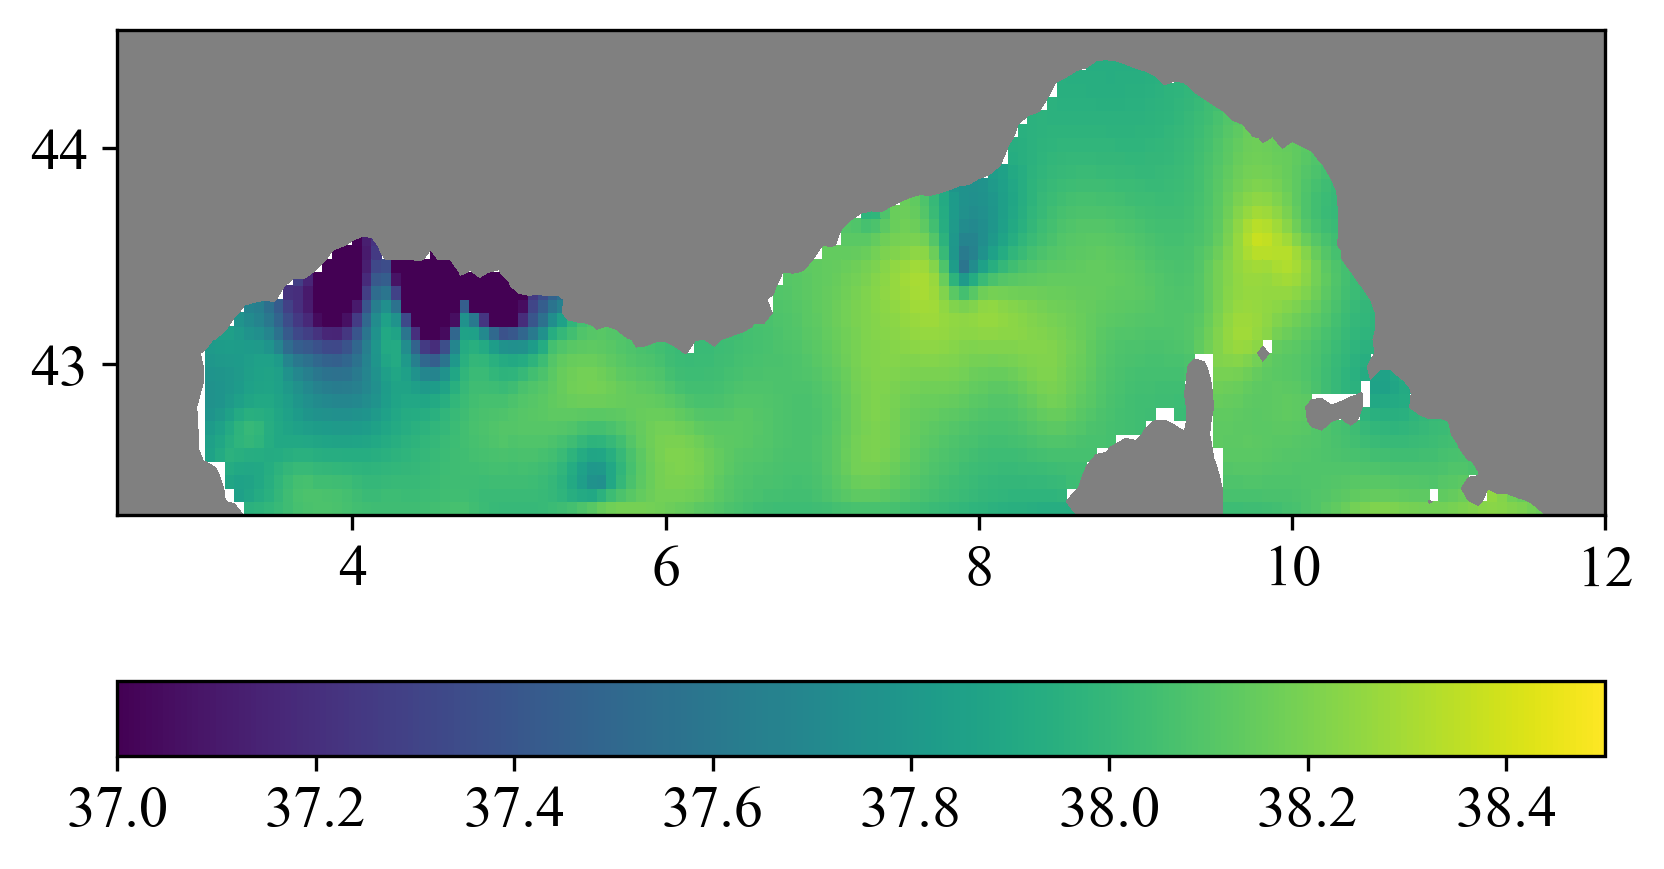

In [11]:
pcolor(xi,yi,fi.+mean(obsval),vmin=37,vmax=38.5);
colorbar(orientation="horizontal")
contourf(bx,by,copy(b'), levels = [-1e5,0],colors = [[.5,.5,.5]])
aspectratio = 1/cos(mean([ylim()...]) * pi/180)
gca().set_aspect(aspectratio)

## Exact error and approximations

Details can be found in the publication:

Approximate and Efficient Methods to Assess Error Fields in Spatial Gridding with Data Interpolating Variational Analysis (DIVA) Beckers, Jean-Marie; Barth, Alexander;  Troupin, Charles, Alvera-Azcarate, A.  *Journal of Atmospheric & Oceanic Technology* (2014), **31(2)**, 515-530     
https://orbi.uliege.be/handle/2268/161069      
https://journals.ametsoc.org/doi/abs/10.1175/JTECH-D-13-00130.1

In the 2D case you can try to calculate the exact error expression. This demands the computationally expensive evaluation of `diag(s.P)` accessible via the analysis returned structure `s`. This is only available with `DIVAndrun`.

In [12]:
# plots the error field `exerr`
function ploterr(exerr; vmin=0, vmax=1.5, cmap="hot_r")
    pcolor(xi,yi,exerr,vmin=vmin, vmax=vmax, cmap=cmap);
    colorbar(orientation="horizontal")
    contourf(bx,by,copy(b'), levels = [-1e5,0],colors = [[.5,.5,.5]])
    plot(obslon, obslat, "k.", markersize=.5)
    ylim(extrema(yi))
    gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))
end

ploterr (generic function with 1 method)

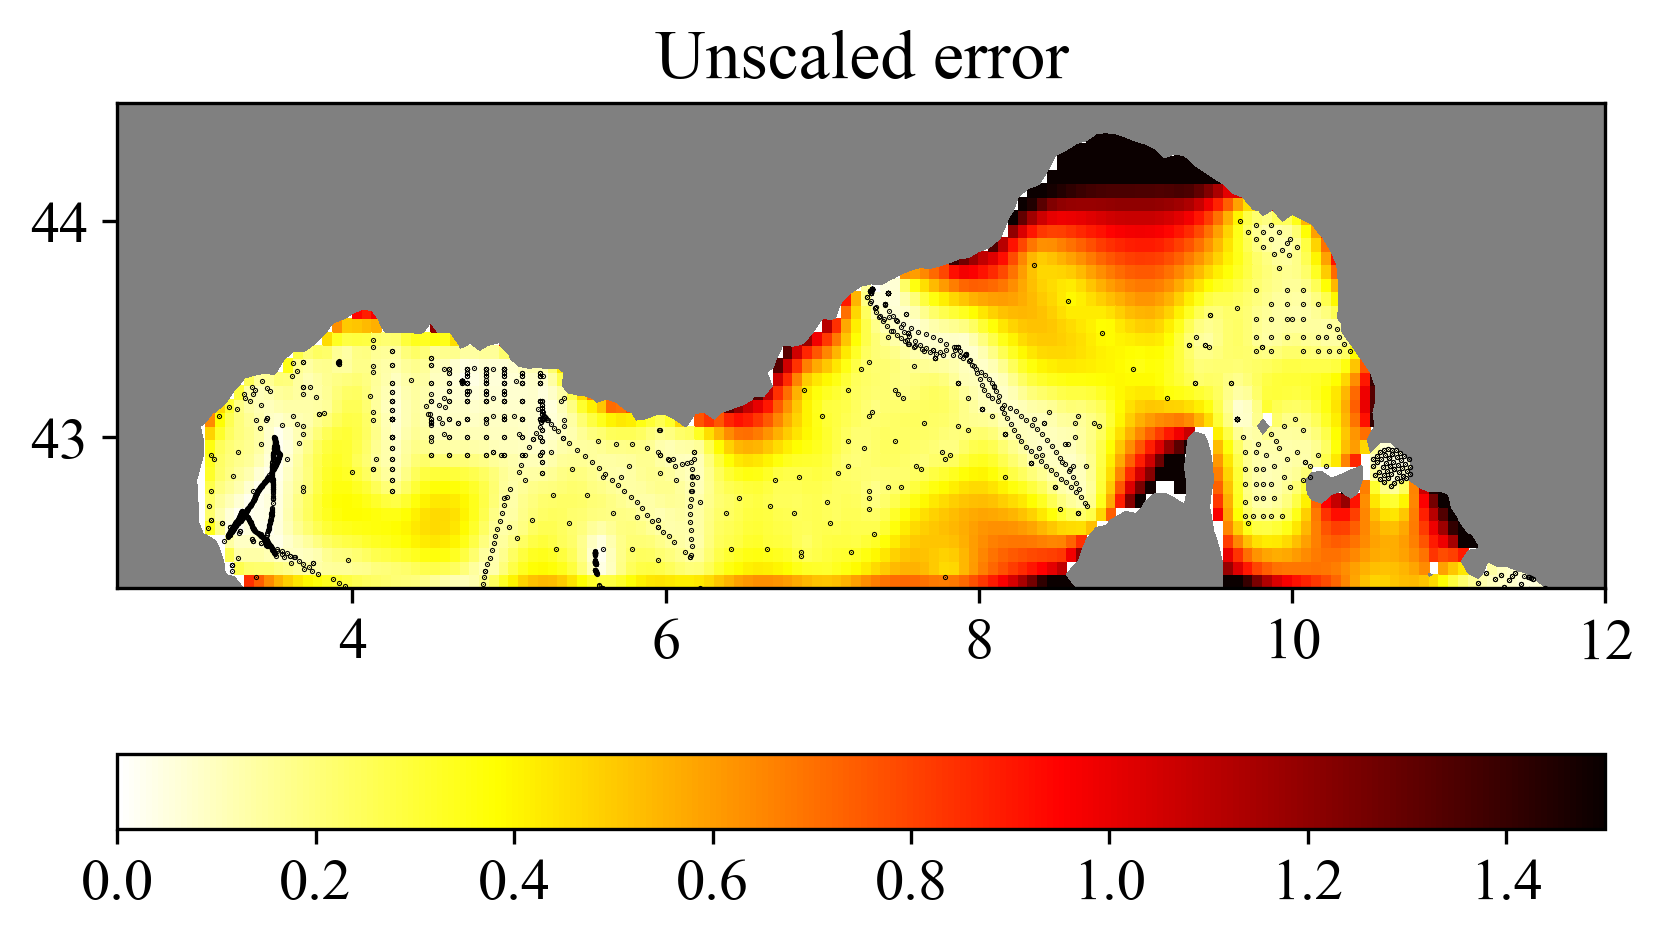

In [13]:
exerr, = statevector_unpack(s.sv,diag(s.P),NaN)
ploterr(exerr)
title("Unscaled error");

Relative error by scaling with background variance `Berr` estimated using data with high errors

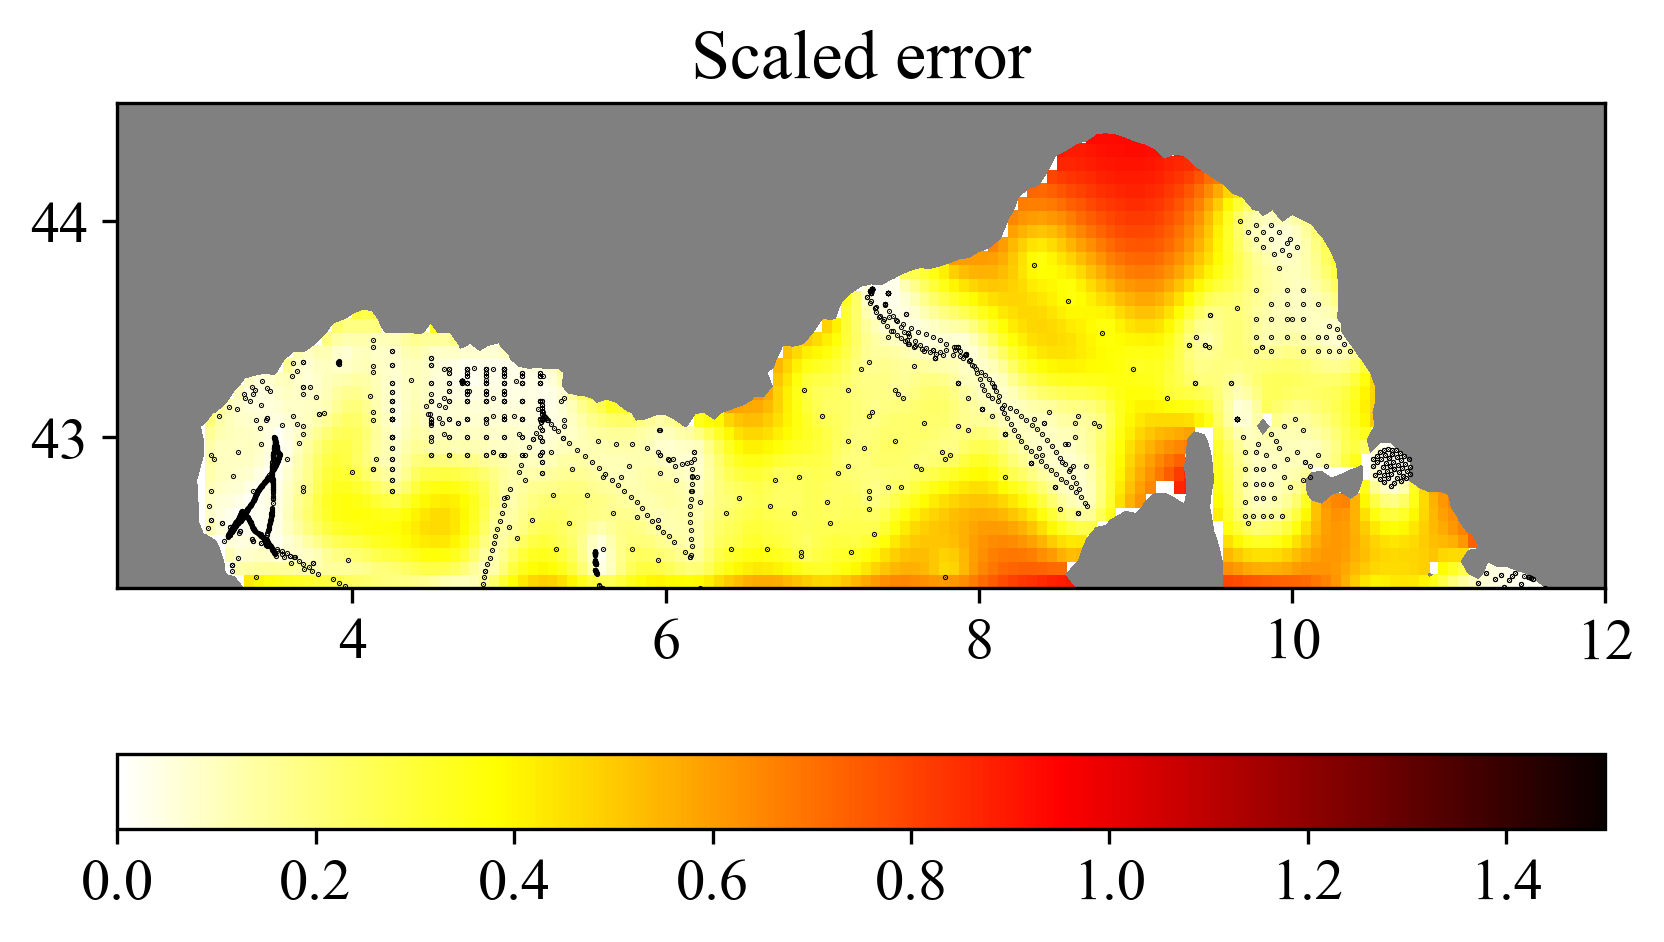

In [14]:
epsilon2huge=1E6
fib,sb = DIVAndrun(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval,len,epsilon2huge);
Berr,= statevector_unpack(sb.sv,diag(sb.P));

ploterr(exerr./Berr)
title("Scaled error");

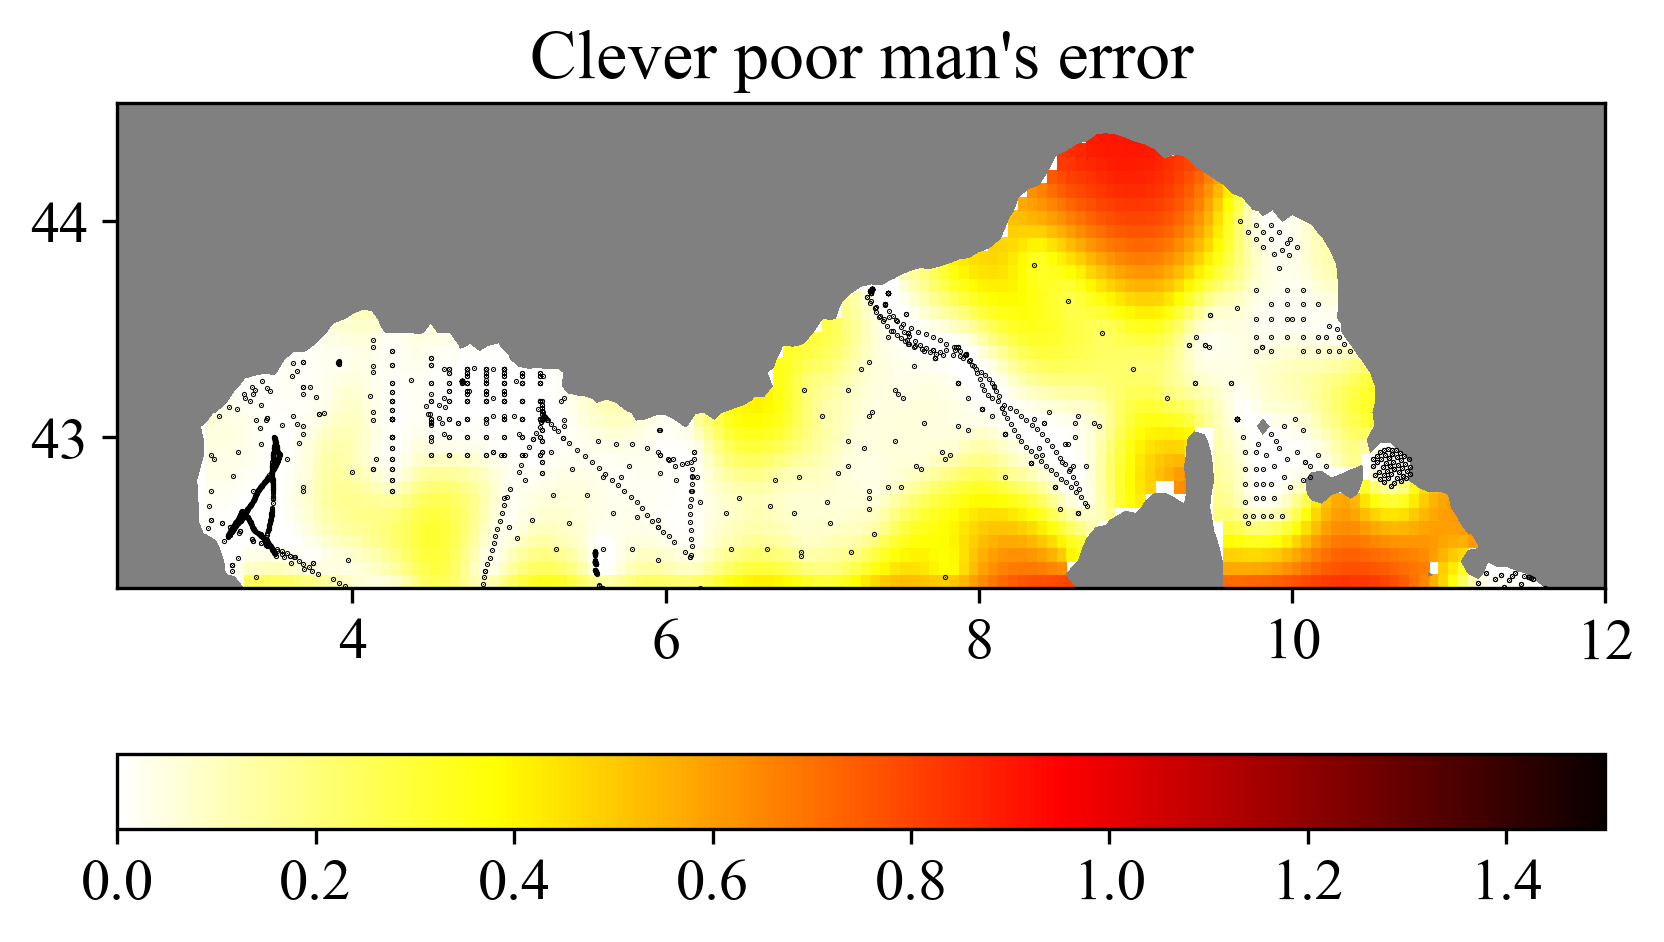

In [15]:
cpme = DIVAnd_cpme(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval,len,epsilon2)

ploterr(cpme)
title("Clever poor man's error");

Do you see any difference between the exact and clever poor man's error ? 
## Difference between error fields
We also overlay the data positions.

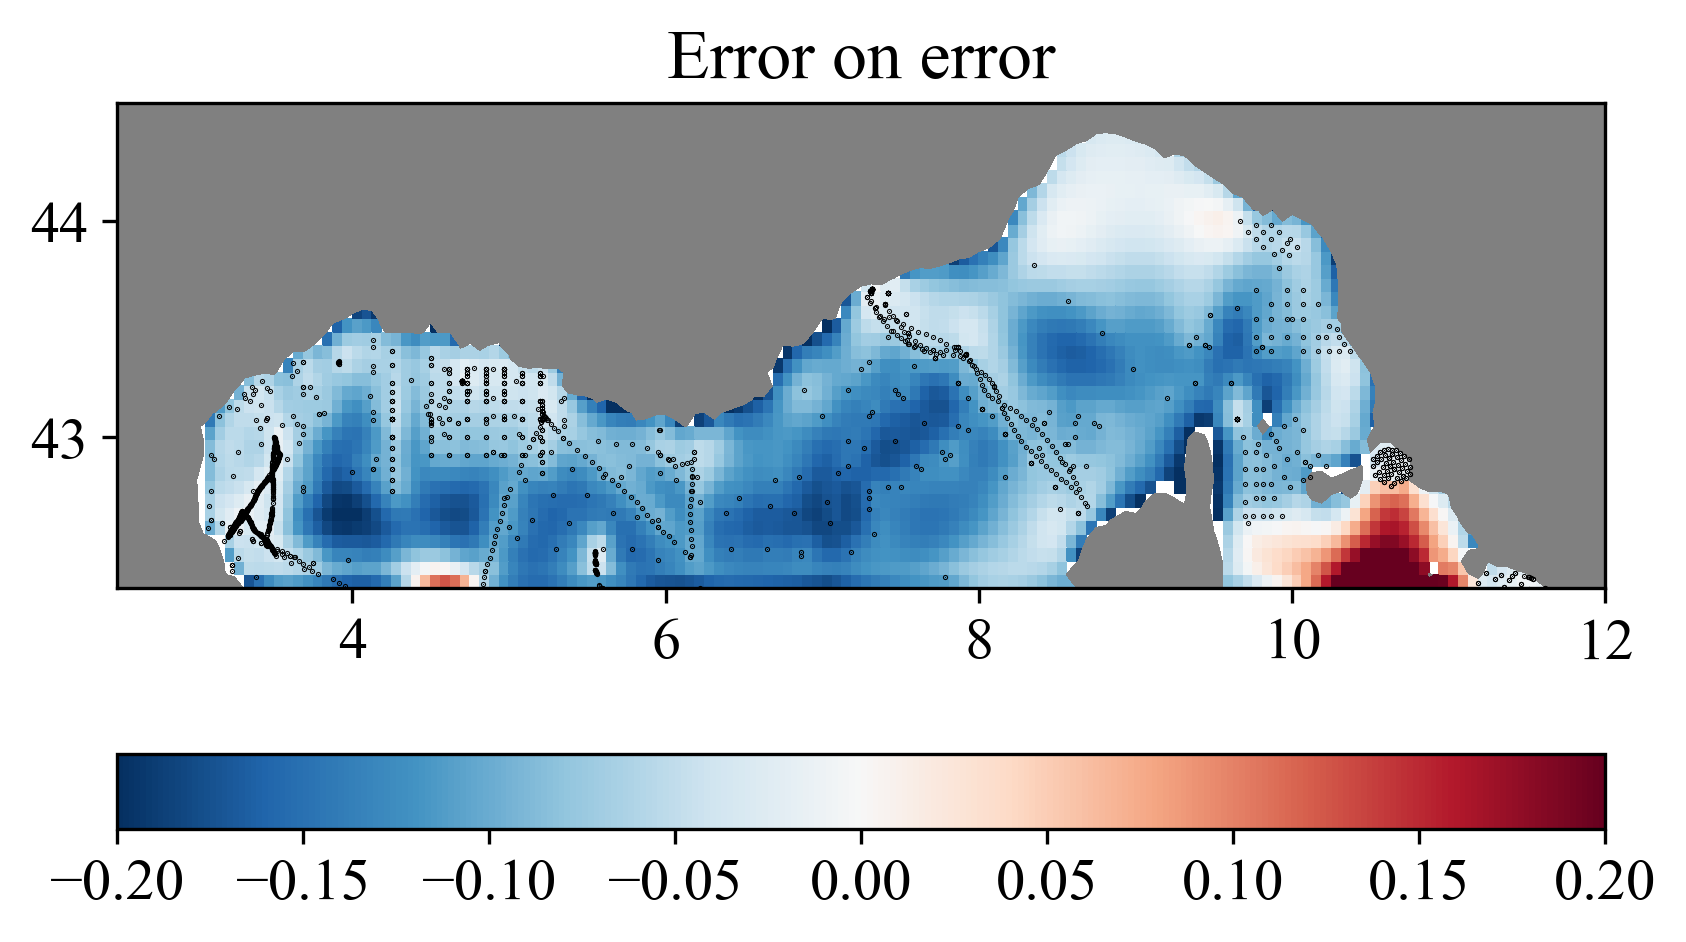

In [16]:
ploterr(cpme-exerr./Berr,vmin=-0.2, vmax=0.2, cmap="RdBu_r")
title("Error on error");

Another approximation to the error field: AEXERR

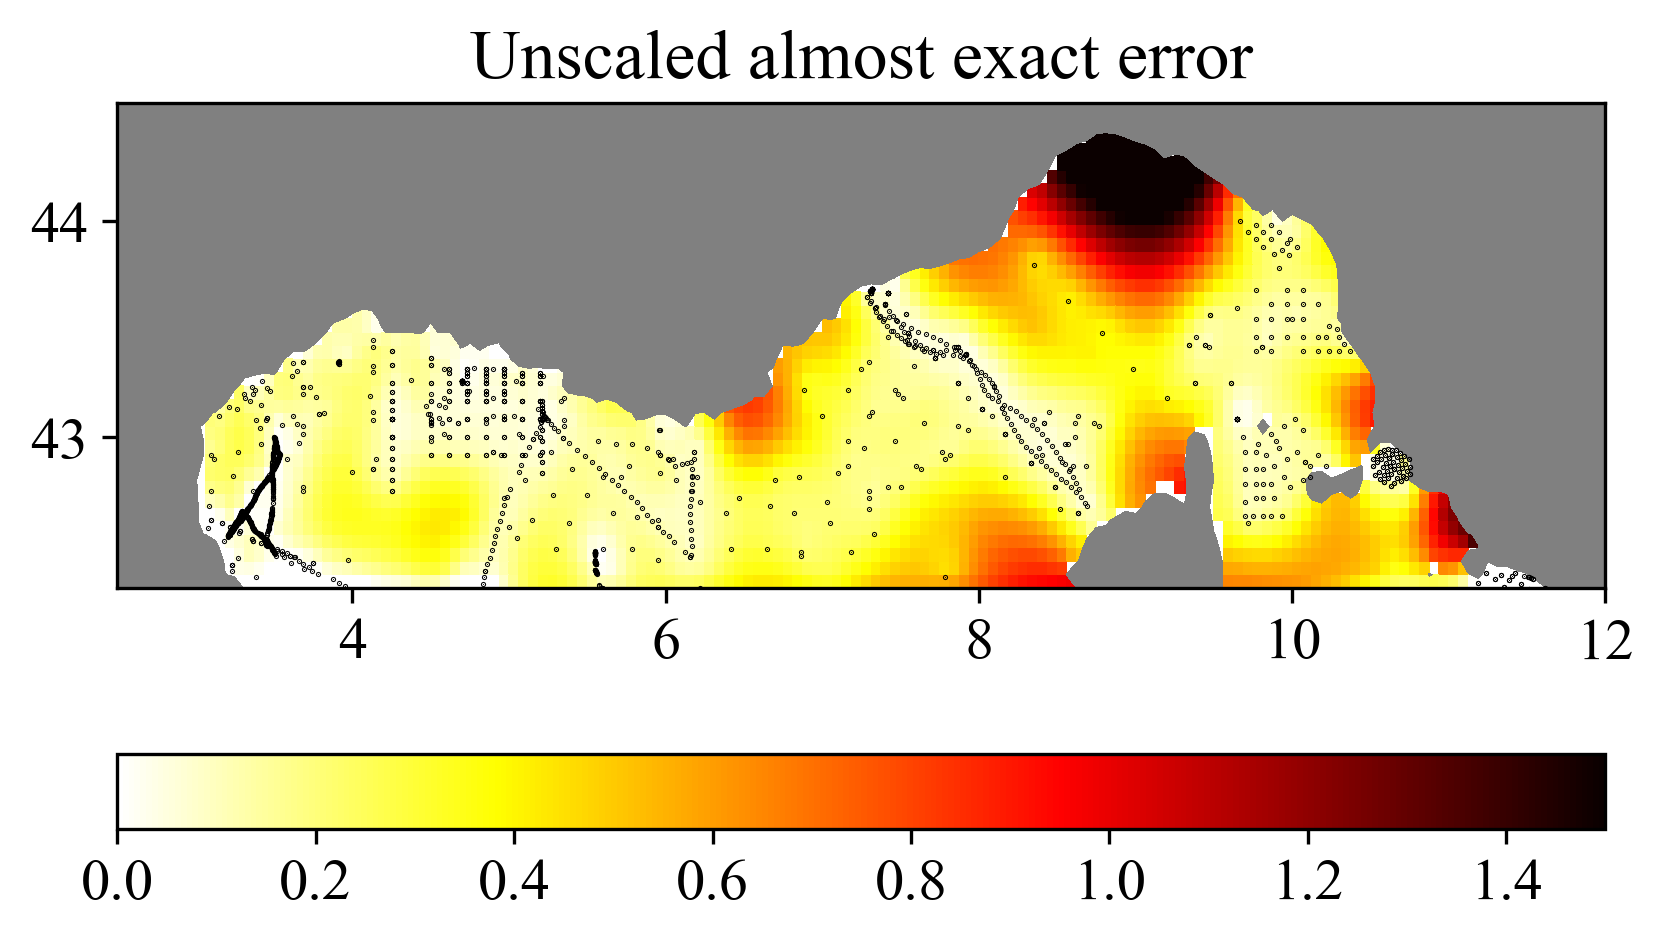

In [17]:
myerr,bjmb,fa,sa = DIVAnd_aexerr(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval,len,epsilon2)
if myerr==0
    @error("No need to approximate error, use direct calculation")
else
    ploterr(myerr)
    title("Unscaled almost exact error")
end;

Scaled AXERR error

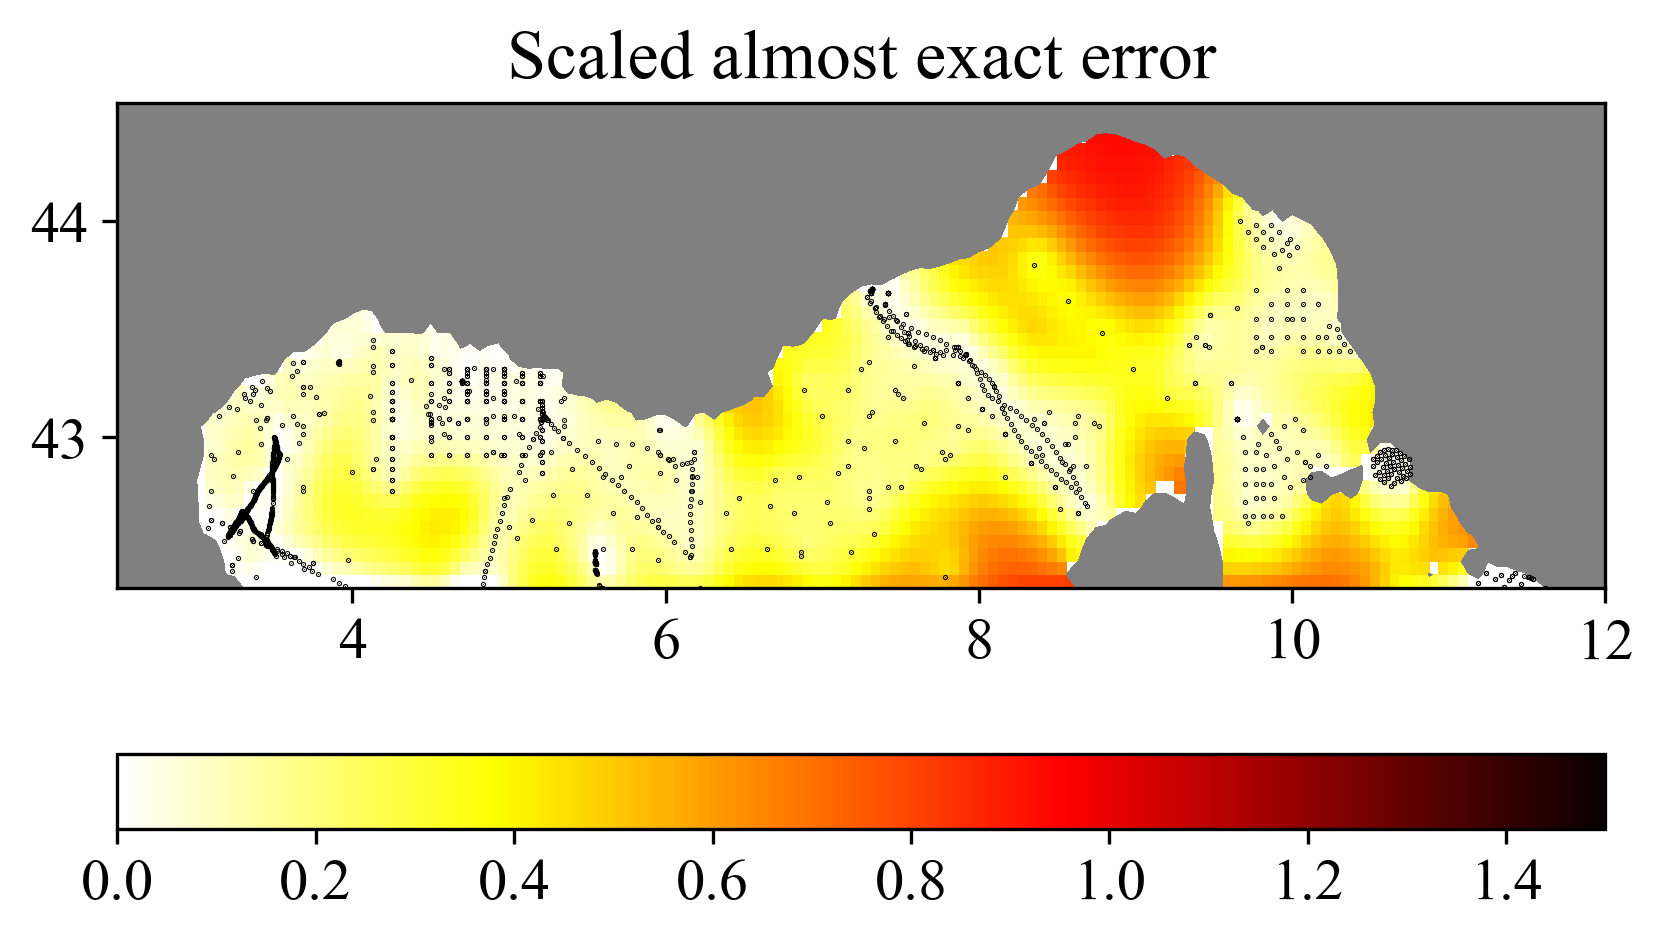

In [18]:
if myerr==0
    @error("No need to approximate error, use direct calculation")
else
    ploterr(myerr./bjmb)
    title("Scaled almost exact error")
end;

# Exercise 
1. Modify the (L, $\epsilon^2$) parameters.
2. Re-run the analysis.
3. See how the error field behaves.

# Conclusion
In view of the uncertainties on statistical parameters (L, $\epsilon^2$), the *clever poor man's error* is generally a sufficient approximation for the error fields.     
This is the one implemented in the `DIVAndgo` high-level analysis function. 